### Load Libraries

In [25]:
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
#import tensorflow.keras as keras
import sklearn.datasets as dt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
#import pickle

### The Breast Cancer Dataset

In [3]:
D=dt.load_breast_cancer()


In [4]:
print(D.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

### Loading data and labels.
### Change the labels of the malignant cases to "1"

In [5]:
X=D.data
y=D.target
y=np.abs(y-1)

### Do a simple division of the dataset (train/test)
### Check the classification results of a support vector machine (with the default parameters)

In [6]:
X1,X2,y1,y2=train_test_split(X,y,test_size=1/3,random_state=42,stratify=y)

In [7]:
svm=SVC()
svm.fit(X1,y1)
y2e=svm.predict(X2)
CM=confusion_matrix(y2,y2e)
print(CM)
print(1-(CM[0,1]+CM[1,0])/X2.shape[0])


[[119   0]
 [ 18  53]]
0.9052631578947369


### Some data dimensions vary a lot compared to others
### This hinders SVM performance

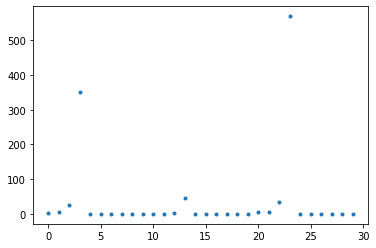

In [8]:
plt.plot(np.std(X,axis=0),'.')

### Normalize the data (mean=0, variance=1) and repeat the tests

In [9]:
sc=StandardScaler().fit(X1)
X1n=sc.transform(X1)
X2n=sc.transform(X2)

In [10]:
svm=SVC()
svm.fit(X1n,y1)
y2e=svm.predict(X2n)
CM=confusion_matrix(y2,y2e)
print(CM)
print(1-(CM[0,1]+CM[1,0])/X2n.shape[0])


[[119   0]
 [  9  62]]
0.9526315789473684


### The results have improved but the number of false negatives is still too high
### Let's calibrate the classifier (choose a different decision threshold from the default value - 0)

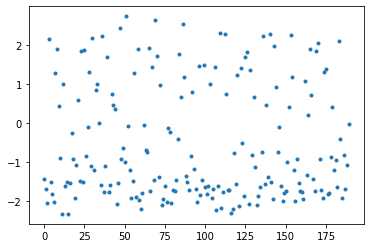

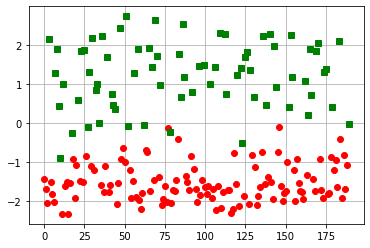

In [12]:
y2da=svm.decision_function(X2n)
t=np.arange(0,190)
plt.plot(t,y2da,'.')
plt.figure()
plt.plot(t[y2==0],y2da[y2==0],'or')
plt.plot(t[y2==1],y2da[y2==1],'sg')

plt.grid(True)

### A threshold of -0.5 seems to do the job

In [13]:
print(confusion_matrix(y2,y2da>=-0.5))


[[115   4]
 [  1  70]]


### Let us check the operating points of the classifier before and after calibration

(-0.05, 1.05, -0.05, 1.05)

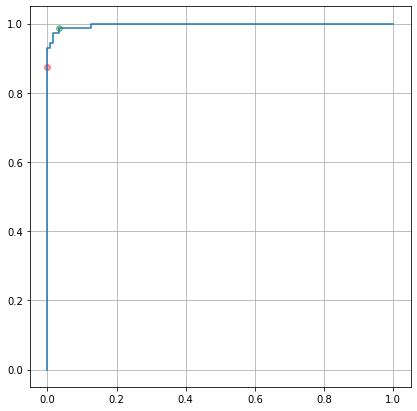

In [18]:
fpa,tpa,t=roc_curve(y2,y2da)
plt.figure(figsize=(7,7))
f1a=0
r1a=62/71
f2a=4/119
r2a=70/71
plt.plot(f1a,r1a,'or',alpha=.4)
plt.plot(f2a,r2a,'og',alpha=.4)
plt.plot(fpa,tpa)
plt.grid(True)
plt.axis('scaled')

### Let us try another classification model

In [20]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression().fit(X1n,y1)
y2db=lr.decision_function(X2n)
print(confusion_matrix(y2,y2db>=0))

[[118   1]
 [  6  65]]


### Compare classifier by looking at the ROC curves
### Note that the operational point of the Logistic classifiers is off - needs calibration
### Also note that for 1 FN, the Logistic classifier can do better than the SVC

(-0.05, 1.05, -0.05, 1.05)

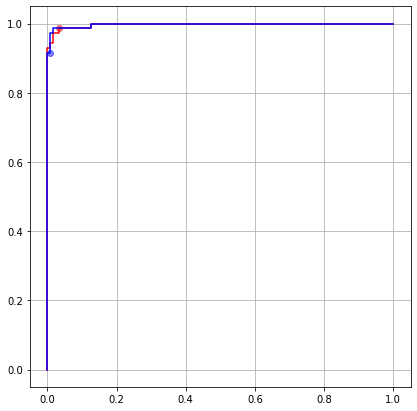

In [23]:
fpa,tpa,t=roc_curve(y2,y2da)
fpb,tpb,t=roc_curve(y2,y2db)
#operating points
#SVC
fa=4/(115+4)
ra=70/(70+1)
#Logistic regression
fb=1/119
rb=65/71
plt.figure(figsize=(7,7))
plt.plot(fa,ra,'or',alpha=.5)
plt.plot(fb,rb,'ob',alpha=.5)
plt.plot(fpa,tpa,'r')
plt.plot(fpb,tpb,'b')
plt.grid(True)
plt.axis('scaled')

### Let's try one more classifier: RandomForest classifier
### Note that this classifier has no "decision_function" but we can use the "predict_prob

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier().fit(X1n,y1)
y2dc=rf.predict_proba(X2n)[:,1] #use the 2nd column (the prob. of the positive class)
print(confusion_matrix(y2,y2dc>=0.5)) #in this case the default is 0.5
#print(confusion_matrix(y2,rf.predict(X2n)))

[[119   0]
 [  7  64]]


### Let us compare the 3 classifiers

(-0.05, 1.05, -0.05, 1.05)

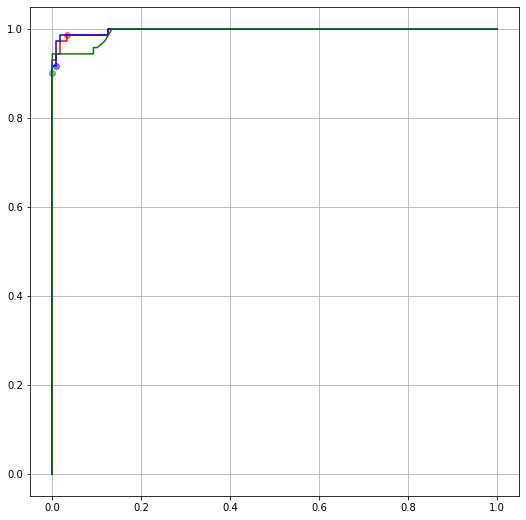

In [33]:
fpa,tpa,t=roc_curve(y2,y2da)
fpb,tpb,t=roc_curve(y2,y2db)
fpc,tpc,t=roc_curve(y2,y2dc)

#operating points
#SVC
fa=4/(115+4)
ra=70/(70+1)
#Logistic regression
fb=1/119
rb=65/71
#Random Forest
fc=0
rc=64/71
plt.figure(figsize=(9,9))
plt.plot(fa,ra,'or',alpha=.5)
plt.plot(fb,rb,'ob',alpha=.5)
plt.plot(fc,rc,'og',alpha=.5)
plt.plot(fpa,tpa,'r')
plt.plot(fpb,tpb,'b')
plt.plot(fpc,tpc,'g')
plt.grid(True)
plt.axis('scaled')